### Algorytmy Macierzowe lab 1

#### Konfiguracja

In [101]:
import numpy as np
from math import log, ceil, pow
from typing import Tuple, List

#### Generowanie macierzy

In [102]:
def generate_matrix(ncols: int, nrows: int):
    return np.random.uniform(low=0.00000001, high=1.0, size=(nrows, ncols))


#### Licznik operacji

In [103]:
class Counter:
    def __init__(self) -> None:
        self.add_counter = 0
        self.mul_counter = 0
        self.div_counter = 0
        self.sub_counter = 0
        self.operation_counter = 0
    
    def add(self, A: np.ndarray , B: np.ndarray) -> np.ndarray:
        self.add_counter += A.size
        self.operation_counter += A.size
        return A + B

    def mul(self, A: np.ndarray , B: np.ndarray) -> np.ndarray:
        self.mul_counter += A.size
        self.operation_counter += A.size
        return A * B
    
    def div(self, A: np.ndarray , B: np.ndarray) -> np.ndarray:
        self.div_counter += A.size
        self.operation_counter += A.size
        return A / B

    def sub(self, A: np.ndarray , B: np.ndarray) -> np.ndarray:
        self.sub_counter += A.size
        self.operation_counter += A.size
        return A - B
    
    def print_counters(self) -> None:
        print(f'Number of add operations: {self.add_counter}')
        print(f'Number of sub operations: {self.sub_counter}')
        print(f'Number of div operations: {self.div_counter}')
        print(f'Number of mul operations: {self.mul_counter}')
        print(f'Number of operations: {self.operation_counter}')
        

#### Funckje pomocniczne

In [104]:
def resize_matrix_to_2n(A: np.ndarray, B: np.ndarray): 
    """Change size of matrix to simplify processing"""
    size_A = A.shape
    size_B = B.shape
    new_height: int = 0
    new_width: int = 0

    if size_A[0] > size_B[0]:
        new_height = find_next_power_of_2(size_A[0])
    else:
        new_height = find_next_power_of_2(size_B[0])
    
    if size_A[1] > size_B[1]:
        new_width = find_next_power_of_2(size_A[1])
    else:
        new_width = find_next_power_of_2(size_B[1])

    new_A = np.pad(A, [(0, new_height - size_A[0]), (0, new_width - size_A[1])], mode='constant')
    new_B = np.pad(B, [(0, new_height - size_B[0]), (0, new_width - size_B[1])], mode='constant')
    return new_A, new_B

def split(array: np.ndarray, nrows: int, ncols: int) -> Tuple:
    """Split a matrix into sub-matrices"""
    r, h = array.shape
    return (array.reshape(h//nrows, nrows, -1, ncols)
                 .swapaxes(1, 2)
                 .reshape(-1, nrows, ncols))


def find_next_power_of_2(number: int) -> int:
    """Finds closest number that is power of 2"""
    return int(pow(2, ceil(log(number)/log(2))))

#### Algorytm Binet'a

In [105]:
A = generate_matrix(5, 5)
B = generate_matrix(5, 5)

def binet_core_algorithm(A: np.ndarray, B: np.ndarray, counter: Counter) -> np.ndarray:
    add = counter.add
    sub = counter.sub
    mul = counter.mul
    if A.size > 1:
        split_at = A.shape[0]//2
        A11, A12, A21, A22 = split(A, split_at, split_at)
        B11, B12, B21, B22 = split(B, split_at, split_at)
        
        C11 = add(binet_core_algorithm(A11, B11, counter), binet_core_algorithm(A12, B21, counter))
        C12 = add(binet_core_algorithm(A11, B12, counter), binet_core_algorithm(A12, B22, counter))
        C21 = add(binet_core_algorithm(A21, B11, counter), binet_core_algorithm(A22, B21, counter))
        C22 = add(binet_core_algorithm(A21, B12, counter), binet_core_algorithm(A22, B22, counter))
        
        return np.concatenate(
            [np.concatenate([C11, C12], axis = 1),
            np.concatenate([C21, C22],axis = 1)],
             axis = 0)
    else:
        return mul(A, B)

def binet_algorithm(A: np.ndarray, B: np.ndarray, counter: Counter) -> np.ndarray:
    new_A, new_B = resize_matrix_to_2n(A, B)
    C = binet_core_algorithm(new_A, new_B, counter)
    C = C[~np.all(C == 0, axis=1)]
    C = C[:, ~np.all(C == 0, axis=0)]
    return C

counter = Counter()
print(binet_algorithm(A, B, counter))
counter.print_counters()
print()
print(A@B)

[[1.23626114 1.28258617 1.37668405 0.59573778 0.94856555]
 [0.81657207 1.54043045 1.37261401 0.64123712 1.02305185]
 [0.62723871 0.34917432 0.58737849 0.56349396 0.77051767]
 [0.83142601 1.24224737 1.39778118 0.93728967 1.40030769]
 [0.92963964 0.85556086 0.73033548 0.68679186 0.74918914]]
Number of add operations: 448
Number of sub operations: 0
Number of div operations: 0
Number of mul operations: 512
Number of operations: 960

[[1.23626114 1.28258617 1.37668405 0.59573778 0.94856555]
 [0.81657207 1.54043045 1.37261401 0.64123712 1.02305185]
 [0.62723871 0.34917432 0.58737849 0.56349396 0.77051767]
 [0.83142601 1.24224737 1.39778118 0.93728967 1.40030769]
 [0.92963964 0.85556086 0.73033548 0.68679186 0.74918914]]


#### Algorytm Strassen'a
https://en.wikipedia.org/wiki/Strassen_algorithm
Wszystkie oznaczenia tak jak tu

In [106]:
A = generate_matrix(2, 2)
B = generate_matrix(2, 2)

def strassen_core_algorith(A: np.ndarray, B: np.ndarray, counter: Counter) -> np.ndarray:
    add = counter.add
    sub = counter.sub
    mul = counter.mul
    if A.size > 1:
        split_at = A.shape[0]//2
        A11, A12, A21, A22 = split(A, split_at, split_at)
        B11, B12, B21, B22 = split(B, split_at, split_at)
        
        M1 = strassen_core_algorith(add(A11, A22), add(B11, B22), counter)
        M2 = strassen_core_algorith(add(A21, A22), B11, counter)
        M3 = strassen_core_algorith(A11, sub(B12, B22), counter)
        M4 = strassen_core_algorith(A22, sub(B21, B11), counter)
        M5 = strassen_core_algorith(add(A11, A12), B22, counter)
        M6 = strassen_core_algorith(sub(A21, A11), add(B11, B12), counter)
        M7 = strassen_core_algorith(sub(A12, A22), add(B21, B22), counter)    

        C11 = add(sub(add(M1, M4), M5), M7)
        C12 = add(M3, M5)
        C21 = add(M2, M4)
        C22 = add(add(sub(M1, M2), M3), M6)

        return np.concatenate(
            [np.concatenate([C11, C12], axis = 1),
            np.concatenate([C21, C22],axis = 1)],
             axis = 0)
    else:
        return mul(A, B)

def strassen_algorith(A: np.ndarray, B: np.ndarray, counter: Counter) -> np.ndarray:
    new_A, new_B = resize_matrix_to_2n(A, B)
    C = strassen_core_algorith(new_A, new_B, counter)
    C = C[~np.all(C == 0, axis=1)]
    C = C[:, ~np.all(C == 0, axis=0)]
    return C

counter = Counter()
print(strassen_algorith(A, B, counter))
counter.print_counters()
print()
print(A@B)

[[0.57267314 0.52127893]
 [0.37738241 0.3564326 ]]
Number of add operations: 12
Number of sub operations: 6
Number of div operations: 0
Number of mul operations: 7
Number of operations: 25

[[0.57267314 0.52127893]
 [0.37738241 0.3564326 ]]


In [107]:
A = generate_matrix(2, 2)
B = generate_matrix(2, 2)

def w_core_algorithm(A: np.ndarray, B: np.ndarray, counter: Counter) -> np.ndarray:
    add = counter.add
    sub = counter.sub
    mul = counter.mul
    if A.size > 1:
        split_at = A.shape[0]//2
        A11, A12, A21, A22 = split(A, split_at, split_at)
        B11, B12, B21, B22 = split(B, split_at, split_at)
        C_A = sub(B12, B11)
        C_D = add(A21, A22)
        A_A = w_core_algorithm(A11, B11, counter)

        U = w_core_algorithm(sub(A21, A11), sub(B12, B22), counter)
        V = w_core_algorithm(C_D, C_A, counter)
        W = add(A_A,
        w_core_algorithm(sub(C_D, A11), sub(B22, C_A), counter))
        W_U = add(W, U)

        C11 =  add(A_A, w_core_algorithm(A12, B21, counter))
        C12 = add(add(W, V), w_core_algorithm(sub(add(A11, A12), C_D), B22, counter))
        C21 = add(W_U, w_core_algorithm(A22, sub(add(B21, C_A), B22), counter))
        C22 = add(W_U, V)
        
        return np.concatenate(
            [np.concatenate([C11, C12], axis = 1),
            np.concatenate([C21, C22],axis = 1)],
             axis = 0)
    else:
        return mul(A, B)

def winograd_algorithm(A: np.ndarray, B: np.ndarray, counter: Counter) -> np.ndarray:
    new_A, new_B = resize_matrix_to_2n(A, B)
    C = w_core_algorithm(new_A, new_B, counter)
    C = C[~np.all(C == 0, axis=1)]
    C = C[:, ~np.all(C == 0, axis=0)]
    return C

counter = Counter()
print(winograd_algorithm(A, B, counter))
counter.print_counters()
print()
print(A@B)

[[0.33636321 0.18547702]
 [0.51516149 0.33731311]]
Number of add operations: 10
Number of sub operations: 7
Number of div operations: 0
Number of mul operations: 7
Number of operations: 24

[[0.33636321 0.18547702]
 [0.51516149 0.33731311]]


#### Wykresy

In [108]:
import matplotlib.pyplot as plt
from time import time
from matplotlib.ticker import FormatStrFormatter


times_binet: List[float] = []
flops_binet: List[int] = []

power_basis = list(range(2, 9))
powers = [2 ** k for k in power_basis]

for k in power_basis:
    A = np.random.rand(2 ** k, 2 ** k)
    B = np.random.rand(2 ** k, 2 ** k)

    counter = Counter()
    start_time: float = time()

    binet_algorithm(A, B, counter)

    total_time: float = time() - start_time

    times_binet.append(total_time)
    flops_binet.append(counter.operation_counter)




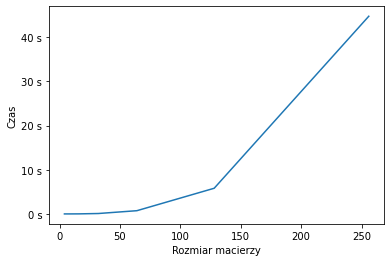

In [120]:
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%d s'))
plt.xlabel("Rozmiar macierzy")
plt.ylabel("Czas")
plt.plot(powers, times_binet)

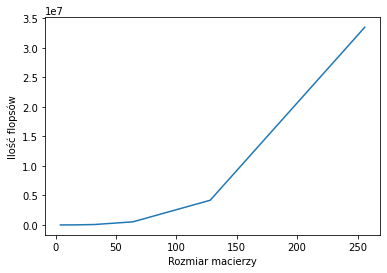

In [118]:
plt.xlabel("Rozmiar macierzy")
plt.ylabel("Ilość flopsów")
plt.plot(powers, flops_binet)

In [111]:
times_strassen: List[float] = []
flops_strassen: List[int] = []

for k in power_basis:
    A = np.random.rand(2 ** k, 2 ** k)
    B = np.random.rand(2 ** k, 2 ** k)

    counter = Counter()
    start_time: float = time()

    strassen_algorith(A, B, counter)

    total_time: float = time() - start_time

    times_strassen.append(total_time)
    flops_strassen.append(counter.operation_counter)

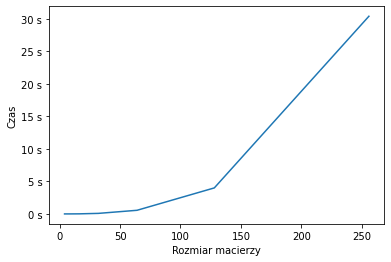

In [119]:
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%d s'))
plt.xlabel("Rozmiar macierzy")
plt.ylabel("Czas")
plt.plot(powers, times_strassen)

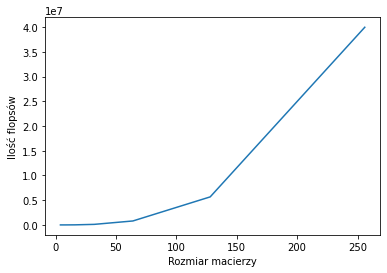

In [121]:
plt.xlabel("Rozmiar macierzy")
plt.ylabel("Ilość flopsów")
plt.plot(powers, flops_strassen)

In [114]:
times_winograd: List[float] = []
flops_winograd: List[int] = []

for k in power_basis:
    A = np.random.rand(2 ** k, 2 ** k)
    B = np.random.rand(2 ** k, 2 ** k)

    counter = Counter()
    start_time: float = time()

    winograd_algorithm(A, B, counter)

    total_time: float = time() - start_time

    times_winograd.append(total_time)
    flops_winograd.append(counter.operation_counter)

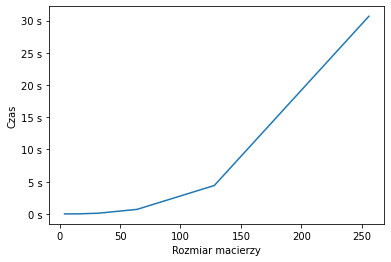

In [115]:
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%d s'))
plt.xlabel("Rozmiar macierzy")
plt.ylabel("Czas")
plt.plot(powers, times_winograd)

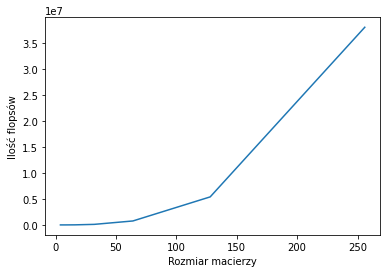

In [116]:
plt.xlabel("Rozmiar macierzy")
plt.ylabel("Ilość flopsów")
plt.plot(powers, flops_winograd)

In [117]:
A = np.array([[1, 3, 5], [2, 4, 6], [3, 5, 7]])
B = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

print(binet_algorithm(A, B, Counter()))

[[ 48  57  66]
 [ 60  72  84]
 [ 72  87 102]]
